# Prérequis
0. Installation des libairies necessaire pour le développement

In [36]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Récupération d'un ensemble de données d'IRM cérébrale
Source : https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

# Importation des bibliothèques

In [37]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2

## Lire les images IRM 

In [38]:
def load_images(directory, img_size=(128, 128)):
    images = []
    path = f'{directory}/*.[jJ][pP][gG]'
    
    for file in glob.iglob(path):
        try:
            # Read and resize image
            img = cv2.imread(file)
            if img is None:
                print(f"Warning: Could not read image {file}")
                continue
                
            img = cv2.resize(img, img_size)
            
            # Convert BGR to RGB (OpenCV loads as BGR by default)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            images.append(img)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    return images

# Load tumor and healthy brain images
tumor = load_images('data/brain_tumor_dataset/yes')
healthy = load_images('data/brain_tumor_dataset/no')

print(f"Loaded {len(tumor)} tumor images and {len(healthy)} healthy images")

Loaded 154 tumor images and 97 healthy images


In [39]:
tumor = np.array(tumor)
healthy = np.array(healthy)

tumor_and_healthy = np.concatenate((healthy, tumor))

In [40]:
healthy.shape
# (amount_of_files, width, height, channel) -> Each channel has a width and height of 128x128 

(97, 128, 128, 3)

## Visualiser les images IRM 

In [41]:
def plot_random(healthy, tumor, num=5):
    # This generates 5(num) numbers from 0 to 96 with no dublicate
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    # Displaying healthy images
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Healthy')
        plt.imshow(healthy_imgs[i])

    # Displaying images with tumors
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Tumor')
        plt.imshow(tumor_imgs[i])

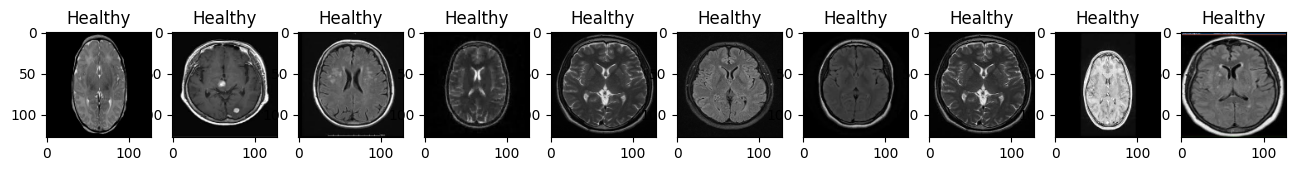

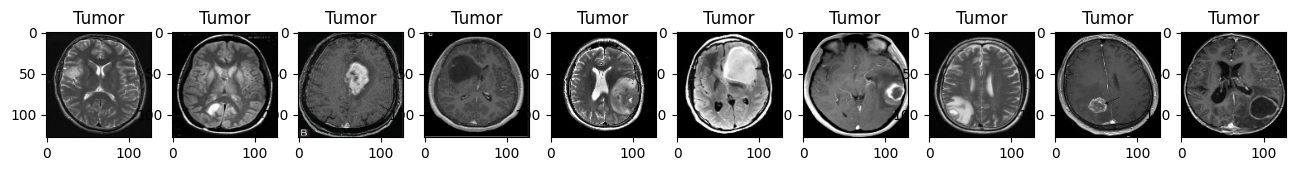

In [42]:
plot_random(healthy, tumor, 10)

## La class Dataset de PyTorch

In [43]:
class Dataset(object):
    """Cette class est une class abstraite representant un Dataset

    Toute autre class de dataset devrait etre une sous class de celle-ci.
    Et chaque class devrait 'Ecraser' ``__len__``, qui retourne la taille du dataset, et
    ``__getitem__``, qui supporte les index en entier qui va de 0 a len(self) exclusive.
    """
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

## Creation de la class IRM 

In [73]:
class IRM(Dataset):
    def __init__(self):

        tumor = []
        healthy = []
        # cv2 - Lis le format BGR par default
        for f in glob.iglob(f"./data/brain_tumor_dataset/yes/*.[jJ][pP][gG]"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1])) # sinon le (shape) sera (h,w,#chanells)
            healthy.append(img)

        for f in glob.iglob(f"./data/brain_tumor_dataset/no/*.[jJ][pP][gG]"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1])) 
            tumor.append(img)

        # Contiens nos images
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        print("Tumor shape", tumor.shape)
        print("Healthy shape", healthy.shape)

        # Nos étiquette
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32) # On veut autant de 1 que des images avec une tumeur
        healthy_label = np.ones(healthy.shape[0], dtype=np.float32)

        # On fusionne ceux avec les tumeurs et ceux sans
        # (100, 512, 512, 3) et (200, 512, 512, 3) = (300, 512, 512, 3)
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': float(self.labels[index])}
        return sample

    def normalize(self):
        self.images /= 255.0

In [74]:
irm = IRM()

Tumor shape (97, 3, 128, 128)
Healthy shape (154, 3, 128, 128)


In [83]:
irm.normalize()

In [75]:
image = irm[5]['image']

In [76]:
image.shape

(3, 128, 128)

In [84]:
np.max(image)

np.float32(0.9882353)